# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Section 1: Data Preparation

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
from matplotlib import pyplot as plt

### Portfolio Data (Offers)

In [3]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
print("Portfolio Data Dimensions: ", portfolio.shape)

Portfolio Data Dimensions:  (10, 6)


In [5]:
# Get data types and dimensions for the profile dataset.
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


### Profile Data (Customers)

In [6]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [7]:
print("Profile Data Dimensions: ", profile.shape)

Profile Data Dimensions:  (17000, 5)


In [8]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [9]:
# Create 'joinDate' column in dataset with properly formatted date data and drop the 'became_member_on' column
profile['joinDate'] = pd.to_datetime(profile.became_member_on.astype(str)).dt.date
profile.drop('became_member_on', axis=1, inplace=True)

In [10]:
# Add new columns for the member's month and year
#profile['joinDate_day'] = profile['joinDate'].apply(lambda x: x.day)
profile['joinDate_month'] = profile['joinDate'].apply(lambda x: x.month)
profile['joinDate_year'] = profile['joinDate'].apply(lambda x: x.year)
profile.head(10)

,age,gender,id,income,joinDate,joinDate_month,joinDate_year
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017-02-12,2,2017
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,7,2017
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018-07-12,7,2018
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,5,2017
4,118,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017-08-04,8,2017
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,2018-04-26,4,2018
6,118,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,2017-09-25,9,2017
7,118,None,68617ca6246f4fbc85e91a2a49552598,NaN,2017-10-02,10,2017
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018-02-09,2,2018
9,118,None,8974fc5686fe429db53ddde067b88302,NaN,2016-11-22,11,2016


### Clean data by removing customers with missing data

There are customers in the dataset with missing age, gender, and income data. Since this is a relatively small portion of the dataset, we will remove these customer entries from the analysis.

In [11]:
profile['gender'].isnull()

0         True
1        False
2         True
3        False
4         True
5        False
6         True
7         True
8        False
9         True
10        True
11        True
12       False
13       False
14       False
15       False
16       False
17        True
18       False
19       False
20       False
21       False
22       False
23        True
24       False
25       False
26        True
27       False
28       False
29       False
         ...  
16970    False
16971    False
16972    False
16973    False
16974    False
16975    False
16976    False
16977     True
16978    False
16979    False
16980     True
16981    False
16982     True
16983    False
16984    False
16985    False
16986    False
16987    False
16988    False
16989     True
16990    False
16991     True
16992    False
16993    False
16994     True
16995    False
16996    False
16997    False
16998    False
16999    False
Name: gender, Length: 17000, dtype: bool

In [12]:
profile.loc[profile['gender'].isnull()].id.count()

2175

In [13]:
# Find customers with missing gender data
print('# of Customers with Missing Data:',profile.loc[profile['gender'].isnull()].id.count(),'of',profile.shape[0])

# of Customers with Missing Data: 2175 of 17000


In [14]:
# View customer data with null gender data
profile.loc[profile['gender'].isnull()].head(10)

,age,gender,id,income,joinDate,joinDate_month,joinDate_year
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017-02-12,2,2017
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018-07-12,7,2018
4,118,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017-08-04,8,2017
6,118,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,2017-09-25,9,2017
7,118,None,68617ca6246f4fbc85e91a2a49552598,NaN,2017-10-02,10,2017
9,118,None,8974fc5686fe429db53ddde067b88302,NaN,2016-11-22,11,2016
10,118,None,c4863c7985cf408faee930f111475da3,NaN,2017-08-24,8,2017
11,118,None,148adfcaa27d485b82f323aaaad036bd,NaN,2015-09-19,9,2015
17,118,None,744d603ef08c4f33af5a61c8c7628d1c,NaN,2017-08-01,8,2017
23,118,None,2b826eba31074a059d63b0ae8f50b7d5,NaN,2017-09-07,9,2017


In [15]:
# Remove customers with null gender values
profile = profile.loc[(profile['gender'].isnull() == False)]

rows, cols = profile.shape
print(f'After this step, we have {rows} rows and {cols} columns.')

After this step, we have 14825 rows and 7 columns.


In [16]:
# Remove customers with null income values if any remain
profile = profile.loc[(profile['income'].isnull() == False)]

rows, cols = profile.shape
print(f'After this step, we have {rows} rows and {cols} columns.')

After this step, we have 14825 rows and 7 columns.


In [17]:
# Remove customers with null age values (equal to 118) if any remain
profile = profile.loc[(profile['age'] != 118)]

rows, cols = profile.shape
print(f'After data preparation, we have {rows} rows and {cols} columns.')

After data preparation, we have 14825 rows and 7 columns.


In [18]:
# View cleaned profile data
profile.head(10)

,age,gender,id,income,joinDate,joinDate_month,joinDate_year
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,7,2017
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,5,2017
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,2018-04-26,4,2018
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018-02-09,2,2018
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017-11-11,11,2017
13,61,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,2017-09-11,9,2017
14,26,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,2014-02-13,2,2014
15,62,F,31dda685af34476cad5bc968bdb01c53,71000.0,2016-02-11,2,2016
16,49,M,62cf5e10845442329191fc246e7bcea3,52000.0,2014-11-13,11,2014
18,57,M,6445de3b47274c759400cd68131d91b4,42000.0,2017-12-31,12,2017


Customers with null or missing data have been removed.

### Transcript Data (Time Series of Events)

In [19]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [20]:
print("Transcript Data Dimensions: ", transcript.shape)

Transcript Data Dimensions:  (306534, 4)


### Section 2: Data Exploration & Analysis

Prior to cleaning data.



### Portfolio Dataset

In [21]:
# Get descriptive statistics on quantitative values
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


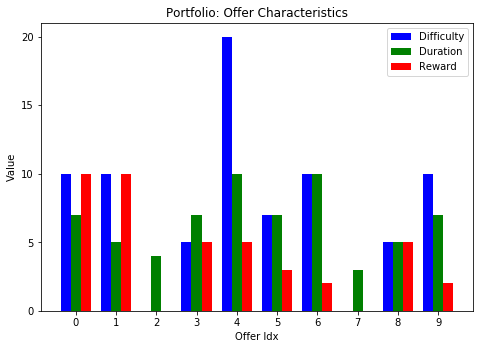

In [22]:
# Create a bar graph of the portfolio dataset's quantitative columns to explore offer characteristics
fig = plt.figure()
X = np.arange(len(portfolio))
ax = fig.add_axes([0,0,1,1])
ax.bar(X - 0.25, portfolio.difficulty, color = 'b', width = 0.25)
ax.bar(X + 0.00, portfolio.duration, color = 'g', width = 0.25)
ax.bar(X + 0.25, portfolio.reward, color = 'r', width = 0.25)
ax.set_xlabel('Offer Idx')
ax.set_ylabel('Value')
ax.set_title('Portfolio: Offer Characteristics')
ax.set_xticks(X)
ax.set_yticks(np.arange(0, 21, 5))
ax.legend(labels=['Difficulty', 'Duration', 'Reward'])
plt.rcParams.update({'font.size': 22})
#ax.set_axisbelow(True)
#plt.grid(True)
plt.show()

### Profile Dataset


In [23]:
# Get data types and dimensions for the profile dataset.
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 7 columns):
age               14825 non-null int64
gender            14825 non-null object
id                14825 non-null object
income            14825 non-null float64
joinDate          14825 non-null object
joinDate_month    14825 non-null int64
joinDate_year     14825 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 926.6+ KB


In [24]:
# Check for duplicate customers
print('Unique Customers:',len(profile.id.unique().tolist()), 'customers out of',len(profile.id.tolist()), 'records.')

Unique Customers: 14825 customers out of 14825 records.


In [25]:
len(profile.id.tolist())

14825

In [26]:
# Get descriptive statistics on quantitative values
profile.age.replace(118,np.nan, inplace=True)

profile.describe()

,age,income,joinDate_month,joinDate_year
count,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,6.695582,2016.620169
std,17.383705,21598.299410,3.488853,1.198245
min,18.000000,30000.000000,1.000000,2013.000000
25%,42.000000,49000.000000,4.000000,2016.000000
50%,55.000000,64000.000000,7.000000,2017.000000
75%,66.000000,80000.000000,10.000000,2017.000000
max,101.000000,120000.000000,12.000000,2018.000000


### Age

In [27]:
# Determine spread of ages for plotting
# Note: 118 means "No Data"

#ageSpread = profile['age'].max() - profile['age'].min()
ageMaxPlt = 101;
numBinsAge = int(ageMaxPlt - profile['age'].min())
#ageMaxPlt = int(profile.age.max());
#print(ageMaxPlt)
print("# of Histogram Bins: ",numBinsAge)

# of Histogram Bins:  83


### Gender

In [28]:
# View number of each gender in dataset.
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [29]:
# Normalize to view gender percentages
np.round(100*profile.gender.value_counts(normalize=True),1)

M    57.2
F    41.3
O     1.4
Name: gender, dtype: float64

### Income

In [30]:
# Number of histogram bins
binSpacing = 1000
numBinsIncome = int((profile.income.max() - profile.income.min())/binSpacing)
print(numBinsIncome)

90


### Plot Data

Text(0.5,1,'Income Distribution')

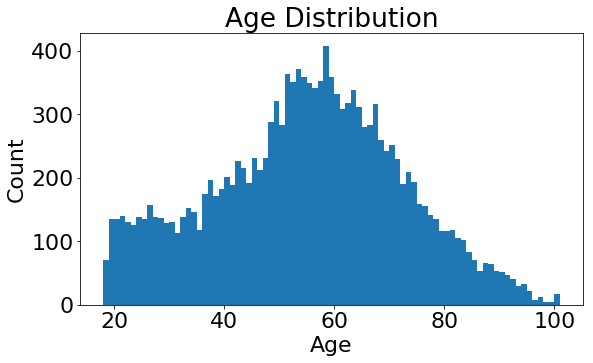

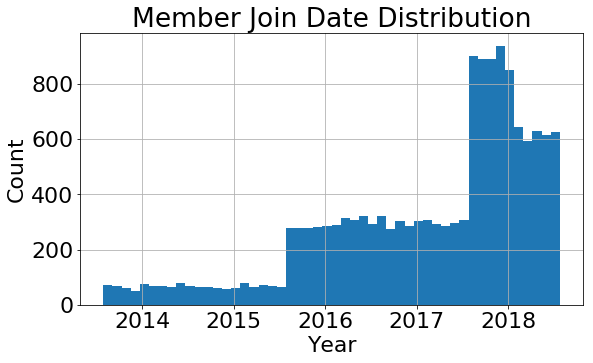

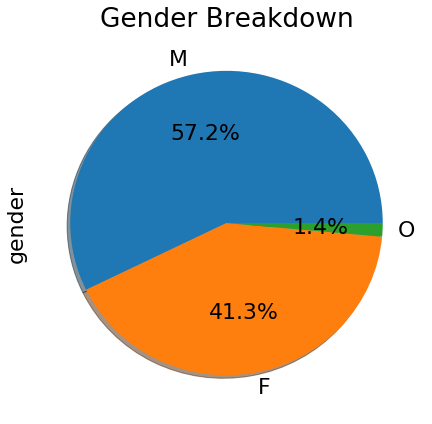

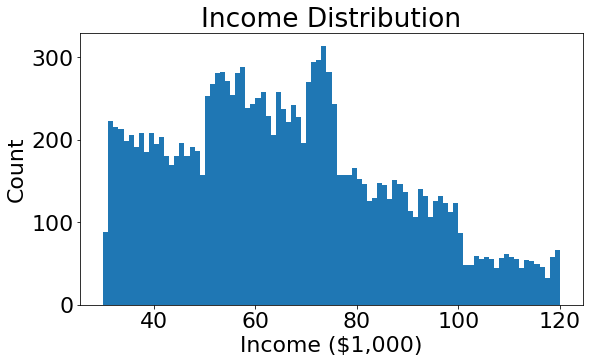

In [31]:
# Plot Data
#plt.subplots(2, 2, figsize=(16, 16))

# Age
#plt.subplot(221)
fig = plt.figure(figsize=(9,5))
plt.hist(profile['age'][~np.isnan(profile['age'])], range=[profile['age'].min(), ageMaxPlt], bins=numBinsAge)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')

# Member Join Date
fig = plt.figure(figsize=(9,5))
profile['joinDate'].hist(bins=50)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Member Join Date Distribution')

# Gender
#plt.subplot(223)
fig = plt.figure()
profile.gender.value_counts().plot.pie(figsize=(7, 7), 
                                       title="Gender Breakdown", 
                                       autopct='%.1f%%', 
                                       shadow=True)

# Income
#plt.subplot(224)
fig = plt.figure(figsize=(9,5))
plt.hist(profile['income'][~np.isnan(profile['income'])]/1000, bins=numBinsIncome)
plt.xlabel('Income ($1,000)')
plt.ylabel('Count')
plt.title('Income Distribution')

### Transcript Dataset


In [32]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [33]:
# Types of events in the transcript dataset
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [34]:
transcript.time.describe()


count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

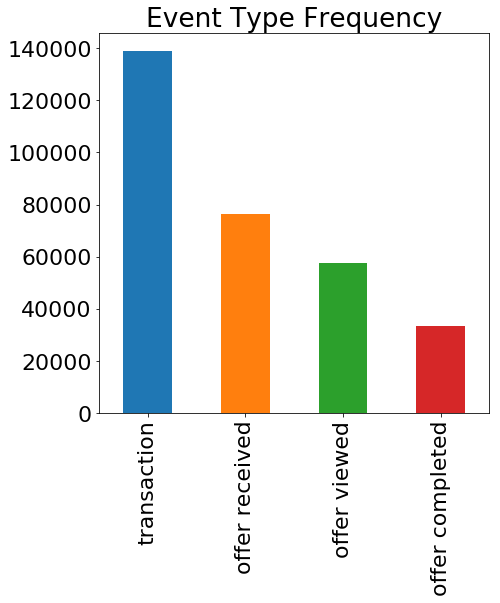

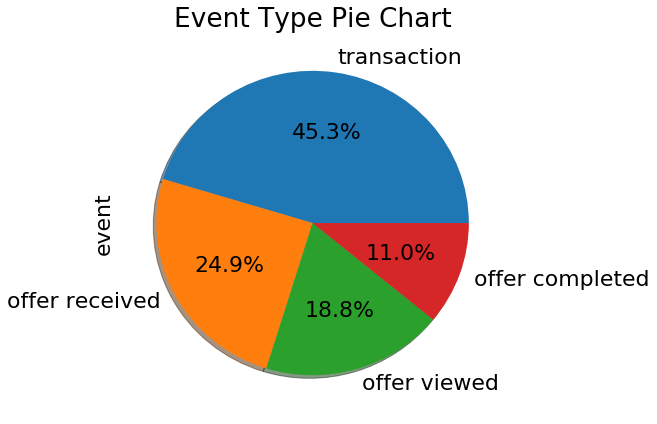

In [35]:
# Create a bar graph of the transcript dataset's quantitative columns to explore offer characteristics
fig = plt.figure()
transcript.event.value_counts().plot.bar(figsize=(7, 7), 
                                         title="Event Type Frequency")

fig = plt.figure()
transcript.event.value_counts().plot.pie(figsize=(7, 7), 
                                       title="Event Type Pie Chart", 
                                       autopct='%.1f%%', 
                                       shadow=True)

In [36]:
# See list of dictionary keys in the value column. Is 'offer_id' the only entry?
valueKeys = transcript.value.apply(lambda x: str(list(x.keys())))

In [37]:
# Cross reference value keys with event types to determine which value keys align with which event types.
pd.crosstab(valueKeys, transcript['event'])

event,offer completed,offer received,offer viewed,transaction
value,,,,
['amount'],0,0,0,138953
['offer id'],0,76277,57725,0
"['offer_id', 'reward']",33579,0,0,0


From the table above, we see that:

transaction events result in an amount value
offer received and offer viewed events result in only an offer_id value
offer completed events result in offer_id and reward values

### View Data as Time Series for Specific Person

In [38]:
# View examples of successfully completed offers
transcript[transcript.event == 'offer completed'].head(10)

,event,person,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
12717,offer completed,227f2d69e46a4899b70d48182822cff6,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
12721,offer completed,bb0f25e23a4c4de6a645527c275cd594,0,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
12744,offer completed,d72d201be5794279aa716d8ad82b8d90,0,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
12764,offer completed,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12767,offer completed,3e621194f72e40d7a0b695ee9b7c38b7,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


In [39]:
# View examples of a randomly chosen customer
transcript[transcript.person == 'bb0f25e23a4c4de6a645527c275cd594']

,event,person,time,value
317,offer received,bb0f25e23a4c4de6a645527c275cd594,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
12720,transaction,bb0f25e23a4c4de6a645527c275cd594,0,{'amount': 28.08}
12721,offer completed,bb0f25e23a4c4de6a645527c275cd594,0,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
40812,offer viewed,bb0f25e23a4c4de6a645527c275cd594,96,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
52288,transaction,bb0f25e23a4c4de6a645527c275cd594,162,{'amount': 21.62}
53492,offer received,bb0f25e23a4c4de6a645527c275cd594,168,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
74855,offer viewed,bb0f25e23a4c4de6a645527c275cd594,186,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
97732,transaction,bb0f25e23a4c4de6a645527c275cd594,264,{'amount': 35.95}
97733,offer completed,bb0f25e23a4c4de6a645527c275cd594,264,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
150932,offer received,bb0f25e23a4c4de6a645527c275cd594,408,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


This customer completes multiple offers.

In [40]:
# View the completed offers for this customer example.
exampleCustOfferComp = transcript[(transcript.event == 'offer completed') & (transcript.person == 'bb0f25e23a4c4de6a645527c275cd594')].value
print(exampleCustOfferComp)

12721     {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
97733     {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
184966    {'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...
232935    {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
291555    {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
Name: value, dtype: object


In [41]:
exampleCustOfferComp.iloc[3]

{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10}

In [42]:
# Return Series as ndarray
exampleCustOfferComp.values

array([{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3},
       {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5},
       {'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7', 'reward': 5},
       {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10},
       {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}], dtype=object)

In [43]:
# View the specific offer with a reward of 10
exampleCustOfferComp.iloc[3]

{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10}

In [44]:
# View the offer that this customer completed
portfolio[portfolio.id == exampleCustOfferComp.iloc[3]['offer_id']]

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10


### Data Transformation


Perform feature engineering by:

. Replacing text columns, such as channels, offer_type, and event with one-hot encoding vectors
. Merge data sets for model training
     . Add customer and offer information to the event transcript using common id
. Drop unused columns

In [45]:
def channels_unique(channelColumn):
    """ Create a list of unique channel values
    
    Input:
    Column of Pandas dataframe representing channels
    
    Returns:
        List of unique channel values
    """
    
    channelsList = []
    for x in channelColumn.values:
        for y in x:
            channelsList.append(y)

    # Use a set to get unique list of channels and return
    return set(channelsList)

In [46]:
# Make a list of all channel entries
channelsUnique = channels_unique(portfolio.channels)
        
print(channelsUnique)

for x in channelsUnique:
    print(x)

{'social', 'email', 'web', 'mobile'}
social
email
web
mobile


In [47]:
def channel_labels(row, chan):
    """Convert channel list into separate columns, with 1 indicating in the list, and 0 otherwise.
    
    Args:
        row (Pandas dataframe row) = current row.
        chan (str) = channel name.
    """
    if chan in row['channels']:
        return 1
    else:
        return 0

In [48]:
def one_hot_channels():
    """ Turns the channels column of the portfolio data set into a one-hot encoding
    
    Returns:
        Pandas dataframe with a one-hot encoding columns for the channel types
    """
    
    # Create a copy.
    p_copy = portfolio.copy()
    
    # One-Hot Encode the channel_list
    for chan in channels_unique(p_copy.channels):
        p_copy["chan_"+chan] = p_copy.apply(lambda row: channel_labels(row, chan), axis=1)
    
    # Drop channels column
    p_copy.drop(columns=['channels'], inplace=True, axis=1)
    
    return p_copy

In [49]:
one_hot_channels()

,difficulty,duration,id,offer_type,reward,chan_social,chan_email,chan_web,chan_mobile
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,0,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,1,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,0,1,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,0,1,1,1


In [50]:
# One-hot encode offer type
pd.get_dummies(portfolio, columns=['offer_type'])

,channels,difficulty,duration,id,reward,offer_type_bogo,offer_type_discount,offer_type_informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,0,1,0
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,0,1
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,0,0
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,2,0,1,0


In [51]:
def reorderColID(dataframe,columnName):
    
    # Reorder columns such that 'id' comes first

    # Get list of columns
    cols = dataframe.columns.tolist()

    # print('Before:',cols)

    # Find index of the 'id' column and move to the front of the list
    cols.insert(0, cols.pop(cols.index(columnName)))

    # print('After:',cols)

    # Use the updated column list to reorder the columns in the dataframe
    dataframe = dataframe[cols]

    # dataframe.head(10)
    
    return dataframe

In [52]:
def portfolioTransform(portfolio):

    # Perform one-hot encoding of the channel column
    portfolio = one_hot_channels()

    # Make a copy of 'offer_type' for plotting purposes
    portfolio['offerType'] = portfolio['offer_type']
    
    # One-hot encode offer type
    portfolio = pd.get_dummies(portfolio, columns=['offer_type'])

    # Reorder columns such that 'id' comes first
    portfolio = reorderColID(portfolio,'id')
    
    portfolio.rename(columns={'id': 'offer_id'}, inplace=True)
    
    # Return dataframe
    return portfolio

In [53]:
portfolioClean = portfolioTransform(portfolio)

In [54]:
# Check portfolio dataframe
portfolioClean.head(10)

,offer_id,difficulty,duration,reward,chan_social,chan_email,chan_web,chan_mobile,offerType,offer_type_bogo,offer_type_discount,offer_type_informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,1,0,1,bogo,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,1,1,1,bogo,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,4,0,0,1,1,1,informational,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,0,1,1,1,bogo,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,0,1,1,0,discount,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,1,1,1,1,discount,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,1,1,1,1,discount,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,1,1,0,1,informational,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,bogo,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,0,1,1,1,discount,0,1,0


### Profile

In [55]:
def profileTransform(profile):
    ''' Transform the profile data frame into the desired feature vectors '''
    
    # One-hot encode genders
    profile = pd.get_dummies(profile, columns=['gender'])

    # Reorder columns such that 'id' comes first
    profile = reorderColID(profile,'id')

    # Rename 'if' to 'customer_id'
    profile.rename(columns={'id': 'customer_id'}, inplace=True)

    return profile

In [56]:
#profile = profileTransform(profile)
profileClean = profileTransform(profile)

In [57]:
profileClean.head(10)

,customer_id,age,income,joinDate,joinDate_month,joinDate_year,gender_F,gender_M,gender_O
1,0610b486422d4921ae7d2bf64640c50b,55,112000.0,2017-07-15,7,2017,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,2017-05-09,5,2017,1,0,0
5,e2127556f4f64592b11af22de27a7932,68,70000.0,2018-04-26,4,2018,0,1,0
8,389bc3fa690240e798340f5a15918d5c,65,53000.0,2018-02-09,2,2018,0,1,0
12,2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,2017-11-11,11,2017,0,1,0
13,aa4862eba776480b8bb9c68455b8c2e1,61,57000.0,2017-09-11,9,2017,1,0,0
14,e12aeaf2d47d42479ea1c4ac3d8286c6,26,46000.0,2014-02-13,2,2014,0,1,0
15,31dda685af34476cad5bc968bdb01c53,62,71000.0,2016-02-11,2,2016,1,0,0
16,62cf5e10845442329191fc246e7bcea3,49,52000.0,2014-11-13,11,2014,0,1,0
18,6445de3b47274c759400cd68131d91b4,57,42000.0,2017-12-31,12,2017,0,1,0


### Create normalized version of Profile data

In [58]:
from sklearn import preprocessing

def normalizePorfolio(df):
    
    # Initialize a min-max scaler object
    #scaler = MinMaxScaler()
    
    normalized_df=(df-df.min())/(df.max()-df.min())

    return normalized_df

In [59]:
normalizeColumns = ['age', 'income', 'joinDate_month', 'joinDate_year']

normalizedPorfolio = normalizePorfolio(profile[normalizeColumns])

In [60]:
normalizedPorfolio.head(10)

,age,income,joinDate_month,joinDate_year
1,0.445783,0.911111,0.545455,0.8
3,0.686747,0.777778,0.363636,0.8
5,0.602410,0.444444,0.272727,1.0
8,0.566265,0.255556,0.090909,1.0
12,0.481928,0.233333,0.909091,0.8
13,0.518072,0.300000,0.727273,0.8
14,0.096386,0.177778,0.090909,0.2
15,0.530120,0.455556,0.090909,0.6
16,0.373494,0.244444,0.909091,0.2
18,0.469880,0.133333,1.000000,0.8


In [61]:
# Create cleaned and normalized 'profile' dataset
profileCleanNormalized = profileClean.copy()
profileCleanNormalized[normalizeColumns] = normalizedPorfolio[normalizeColumns]

profileCleanNormalized.head(10)

,customer_id,age,income,joinDate,joinDate_month,joinDate_year,gender_F,gender_M,gender_O
1,0610b486422d4921ae7d2bf64640c50b,0.445783,0.911111,2017-07-15,0.545455,0.8,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,0.686747,0.777778,2017-05-09,0.363636,0.8,1,0,0
5,e2127556f4f64592b11af22de27a7932,0.602410,0.444444,2018-04-26,0.272727,1.0,0,1,0
8,389bc3fa690240e798340f5a15918d5c,0.566265,0.255556,2018-02-09,0.090909,1.0,0,1,0
12,2eeac8d8feae4a8cad5a6af0499a211d,0.481928,0.233333,2017-11-11,0.909091,0.8,0,1,0
13,aa4862eba776480b8bb9c68455b8c2e1,0.518072,0.300000,2017-09-11,0.727273,0.8,1,0,0
14,e12aeaf2d47d42479ea1c4ac3d8286c6,0.096386,0.177778,2014-02-13,0.090909,0.2,0,1,0
15,31dda685af34476cad5bc968bdb01c53,0.530120,0.455556,2016-02-11,0.090909,0.6,1,0,0
16,62cf5e10845442329191fc246e7bcea3,0.373494,0.244444,2014-11-13,0.909091,0.2,0,1,0
18,6445de3b47274c759400cd68131d91b4,0.469880,0.133333,2017-12-31,1.000000,0.8,0,1,0


In [62]:
normalizeColumns = ['age', 'income', 'joinDate_month', 'joinDate_year', 'gender_F', 'gender_M', 'gender_O']

profileCleanNormalizedSelect = profileCleanNormalized[normalizeColumns]

In [63]:
profileCleanNormalizedSelect.head(10)

,age,income,joinDate_month,joinDate_year,gender_F,gender_M,gender_O
1,0.445783,0.911111,0.545455,0.8,1,0,0
3,0.686747,0.777778,0.363636,0.8,1,0,0
5,0.602410,0.444444,0.272727,1.0,0,1,0
8,0.566265,0.255556,0.090909,1.0,0,1,0
12,0.481928,0.233333,0.909091,0.8,0,1,0
13,0.518072,0.300000,0.727273,0.8,1,0,0
14,0.096386,0.177778,0.090909,0.2,0,1,0
15,0.530120,0.455556,0.090909,0.6,1,0,0
16,0.373494,0.244444,0.909091,0.2,0,1,0
18,0.469880,0.133333,1.000000,0.8,0,1,0


In [64]:
normalizeColumns = ['age', 'income', 'joinDate_month', 'joinDate_year', 'gender_F', 'gender_M', 'gender_O']

profileCleanNormalizedSelect = profileCleanNormalized[normalizeColumns]

In [65]:
profileCleanNormalizedSelect.head(10)


,age,income,joinDate_month,joinDate_year,gender_F,gender_M,gender_O
1,0.445783,0.911111,0.545455,0.8,1,0,0
3,0.686747,0.777778,0.363636,0.8,1,0,0
5,0.602410,0.444444,0.272727,1.0,0,1,0
8,0.566265,0.255556,0.090909,1.0,0,1,0
12,0.481928,0.233333,0.909091,0.8,0,1,0
13,0.518072,0.300000,0.727273,0.8,1,0,0
14,0.096386,0.177778,0.090909,0.2,0,1,0
15,0.530120,0.455556,0.090909,0.6,1,0,0
16,0.373494,0.244444,0.909091,0.2,0,1,0
18,0.469880,0.133333,1.000000,0.8,0,1,0


### Apply Principle Component Analysis (PCA)

Apply PCA for dimensionality reduction. Determine whether we can apply meaningful dimensionality reduction before clusting for customer segmentation.

In [66]:
import numpy as np
from sklearn.decomposition import PCA

X = profileCleanNormalizedSelect
pca = PCA(n_components=3)
pca.fit(X)

print('Explained Variance:',pca.explained_variance_ratio_)

print('Sum of Explained Variance:',np.sum(pca.explained_variance_ratio_))

print('Singular Values:',pca.singular_values_)

Explained Variance: [ 0.63750642  0.14433764  0.08289721]
Sum of Explained Variance: 0.864741275793
Singular Values: [ 84.79831389  40.34918223  30.57841033]


In [67]:
def transcriptTransform(transcript):
    ''' Transform features in transcript. '''
    
    # Rename 'if' to 'customer_id'
    transcript.rename(columns={'person': 'customer_id'}, inplace=True)
    
    # Expand dictionary values to be dataframe columns
    
    transcript['offer id'] = transcript.value.apply(lambda x: x.get('offer id'))
    transcript['offer_id'] = transcript.value.apply(lambda x: x.get('offer_id'))  # There are a few items in the dataframe that are mislabeled
    transcript['rewardReceived'] = transcript.value.apply(lambda x: x.get('reward'))
    transcript['amountSpent'] = transcript.value.apply(lambda x: x.get('amount'))
    
    #
    transcript['offer_id'] = transcript.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)

    # Drop redundant 'offer id' and 'value' columns
    transcript.drop(['offer id','value'], axis=1, inplace=True)
    
    # Replace 'None' and 'NaN' with 0 values
    transcript.fillna(0, inplace=True)
    
    return transcript

In [68]:
transcriptClean = transcriptTransform(transcript)

In [69]:
transcriptClean.head(10)


,event,customer_id,time,offer_id,rewardReceived,amountSpent
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0.0
6,offer received,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,0.0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0.0,0.0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
9,offer received,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0


### Merge Data

In [70]:
def merge_data(portfolio,profile,transcript):
    """
    Merge cleaned data frames for EDA
       
    Parameters
    ---------- 
    portfolio : cleaned portfolio data frame
    profile : cleaned profile data frame
    transcript : cleaned transcript data frame
      
    Returns
    -------
    merged_df: merged data frame
    
    """
    
    #merged_df = pd.merge(transcript, profile, on='customer_id')
    merged_df = pd.merge(portfolio, transcript, on='offer_id')
    merged_df = pd.merge(merged_df, profile, on='customer_id')
    
    return merged_df

In [71]:
merged_df = merge_data(portfolioClean,profileClean,transcriptClean)

In [73]:
portfolioClean.to_pickle("processedData/portfolioClean_v1.pkl")
profileClean.to_pickle("processedData/profileClean_v1.pkl")
transcriptClean.to_pickle("processedData/transcriptClean_v1.pkl")

In [74]:
merged_df.head(10)

,offer_id,difficulty,duration,reward,chan_social,chan_email,chan_web,chan_mobile,offerType,offer_type_bogo,...,rewardReceived,amountSpent,age,income,joinDate,joinDate_month,joinDate_year,gender_F,gender_M,gender_O
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,1,0,1,bogo,1,...,0.0,0.0,64,100000.0,2017-09-09,9,2017,0,1,0
1,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,1,0,1,bogo,1,...,0.0,0.0,64,100000.0,2017-09-09,9,2017,0,1,0
2,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,1,0,1,bogo,1,...,0.0,0.0,64,100000.0,2017-09-09,9,2017,0,1,0
3,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,1,0,1,bogo,1,...,0.0,0.0,64,100000.0,2017-09-09,9,2017,0,1,0
4,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,1,0,1,bogo,1,...,10.0,0.0,64,100000.0,2017-09-09,9,2017,0,1,0
5,3f207df678b143eea3cee63160fa8bed,0,4,0,0,1,1,1,informational,0,...,0.0,0.0,64,100000.0,2017-09-09,9,2017,0,1,0
6,3f207df678b143eea3cee63160fa8bed,0,4,0,0,1,1,1,informational,0,...,0.0,0.0,64,100000.0,2017-09-09,9,2017,0,1,0
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,0,1,1,0,discount,0,...,0.0,0.0,64,100000.0,2017-09-09,9,2017,0,1,0
8,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,0,1,1,0,discount,0,...,0.0,0.0,64,100000.0,2017-09-09,9,2017,0,1,0
9,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,0,1,1,0,discount,0,...,5.0,0.0,64,100000.0,2017-09-09,9,2017,0,1,0


In [75]:
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 148804
Data columns (total 25 columns):
offer_id                    148805 non-null object
difficulty                  148805 non-null int64
duration                    148805 non-null int64
reward                      148805 non-null int64
chan_social                 148805 non-null int64
chan_email                  148805 non-null int64
chan_web                    148805 non-null int64
chan_mobile                 148805 non-null int64
offerType                   148805 non-null object
offer_type_bogo             148805 non-null uint8
offer_type_discount         148805 non-null uint8
offer_type_informational    148805 non-null uint8
event                       148805 non-null object
customer_id                 148805 non-null object
time                        148805 non-null int64
rewardReceived              148805 non-null float64
amountSpent                 148805 non-null float64
age                         148

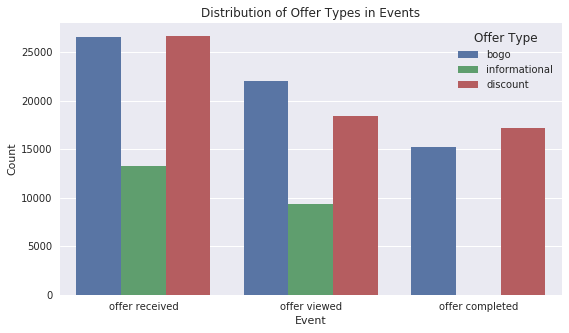

In [78]:
import seaborn as sns

# Plot the distribution of different offer types ('offerType') in the 'events' column
plt.figure(figsize=(9, 5))
ax = sns.countplot(x="event", hue="offerType", data=merged_df)
sns.set(style="darkgrid")
plt.title('Distribution of Offer Types in Events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Offer Type');

### Customer Segmentation


Use a clustering algorithm to group customers into distinct customer segments for promotion targeting.

In [80]:
#Import KMeans and PCA modules
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def plotKMeans(data, n_clusters):

    # Run PCA to reduce data to three principle dimensions
    pca = PCA(n_components=3)

    #Transform the data
    df = pca.fit_transform(data)

    print('Sum of Explained Variance:',np.sum(pca.explained_variance_ratio_))
        
    #Initialize the class object
    kmeans = KMeans(n_clusters)

    #predict the labels of clusters.
    label = kmeans.fit_predict(df)

    #Getting unique labels
    u_labels = np.unique(label)

    #Getting the Centroids
    centroids = kmeans.cluster_centers_
    u_labels = np.unique(label)

    #plotting the results:
    plt.figure(figsize=(16, 9))
    ax = plt.axes(projection='3d')
    for i in u_labels:
        ax.scatter(df[label == i , 0] , df[label == i , 1], df[label == i , 2], label = i, cmap='viridis')
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 100, color = 'k')
    plt.legend()
    plt.show()
    
    return label

Sum of Explained Variance: 0.864741275793


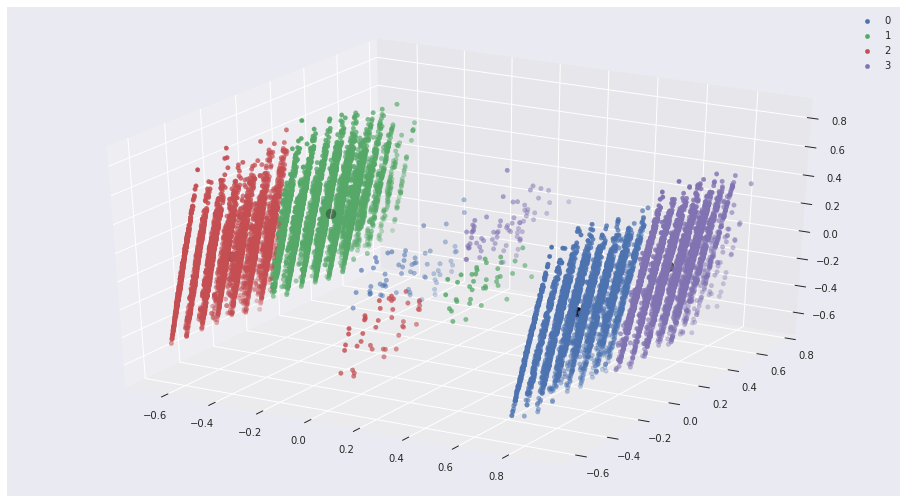

[0 0 2 ..., 2 0 0]


In [81]:
segmentLabels = plotKMeans(profileCleanNormalizedSelect, n_clusters=4)

print(segmentLabels)

In [82]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 15)
 
X = profileCleanNormalizedSelect
    
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [83]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 11279.500581001863
2 : 4196.341634551212
3 : 3469.9706417754132
4 : 2960.504308209878
5 : 2737.820823778544
6 : 2343.8396809161386
7 : 2168.2609631101104
8 : 1984.2360602509827
9 : 1845.277581987451
10 : 1722.81938539981
11 : 1618.4674133497056
12 : 1550.075270682394
13 : 1475.5899984450734
14 : 1416.7942661448333


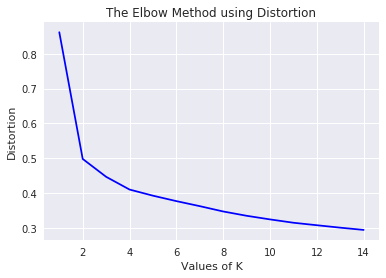

In [84]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [85]:
# Add customer segment labels to the the cleaned profile dataset

print(profileClean.index)
profileClean['customerSegment'] = segmentLabels

print(len(segmentLabels))

profileClean

Int64Index([    1,     3,     5,     8,    12,    13,    14,    15,    16,
               18,
            ...
            16987, 16988, 16990, 16992, 16993, 16995, 16996, 16997, 16998,
            16999],
           dtype='int64', length=14825)
14825


,customer_id,age,income,joinDate,joinDate_month,joinDate_year,gender_F,gender_M,gender_O,customerSegment
1,0610b486422d4921ae7d2bf64640c50b,55,112000.0,2017-07-15,7,2017,1,0,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,2017-05-09,5,2017,1,0,0,0
5,e2127556f4f64592b11af22de27a7932,68,70000.0,2018-04-26,4,2018,0,1,0,2
8,389bc3fa690240e798340f5a15918d5c,65,53000.0,2018-02-09,2,2018,0,1,0,2
12,2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,2017-11-11,11,2017,0,1,0,1
13,aa4862eba776480b8bb9c68455b8c2e1,61,57000.0,2017-09-11,9,2017,1,0,0,3
14,e12aeaf2d47d42479ea1c4ac3d8286c6,26,46000.0,2014-02-13,2,2014,0,1,0,2
15,31dda685af34476cad5bc968bdb01c53,62,71000.0,2016-02-11,2,2016,1,0,0,0
16,62cf5e10845442329191fc246e7bcea3,49,52000.0,2014-11-13,11,2014,0,1,0,1
18,6445de3b47274c759400cd68131d91b4,57,42000.0,2017-12-31,12,2017,0,1,0,1


In [86]:
# Descriptive statistics for all customers
profileClean.describe()

,age,income,joinDate_month,joinDate_year,gender_F,gender_M,gender_O,customerSegment
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,6.695582,2016.620169,0.413423,0.572277,0.014300,1.492344
std,17.383705,21598.299410,3.488853,1.198245,0.492464,0.494765,0.118729,1.046200
min,18.000000,30000.000000,1.000000,2013.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,49000.000000,4.000000,2016.000000,0.000000,0.000000,0.000000,1.000000
50%,55.000000,64000.000000,7.000000,2017.000000,0.000000,1.000000,0.000000,1.000000
75%,66.000000,80000.000000,10.000000,2017.000000,1.000000,1.000000,0.000000,2.000000
max,101.000000,120000.000000,12.000000,2018.000000,1.000000,1.000000,1.000000,3.000000


In [87]:
# Descriptive statistics for customer segment '0'
profileClean[profileClean.customerSegment == 0].describe()

,age,income,joinDate_month,joinDate_year,gender_F,gender_M,gender_O,customerSegment
count,3092.000000,3092.000000,3092.000000,3092.00000,3092.000000,3092.0,3092.000000,3092.0
mean,57.471863,71302.069858,3.797865,2017.09185,0.980272,0.0,0.019728,0.0
std,16.625595,22041.341313,1.952747,0.95243,0.139088,0.0,0.139088,0.0
min,18.000000,30000.000000,1.000000,2014.00000,0.000000,0.0,0.000000,0.0
25%,48.000000,55000.000000,2.000000,2016.00000,1.000000,0.0,0.000000,0.0
50%,58.000000,71000.000000,4.000000,2017.00000,1.000000,0.0,0.000000,0.0
75%,68.250000,87000.000000,5.000000,2018.00000,1.000000,0.0,0.000000,0.0
max,101.000000,120000.000000,7.000000,2018.00000,1.000000,0.0,1.000000,0.0


In [88]:
# Descriptive statistics for customer segment '1'
profileClean[profileClean.customerSegment == 1].describe()

,age,income,joinDate_month,joinDate_year,gender_F,gender_M,gender_O,customerSegment
count,4510.000000,4510.000000,4510.000000,4510.000000,4510.0,4510.000000,4510.000000,4510.0
mean,52.022838,61573.614191,9.364523,2016.067627,0.0,0.991353,0.008647,1.0
std,17.326619,20398.758546,1.895748,1.184881,0.0,0.092599,0.092599,0.0
min,18.000000,30000.000000,4.000000,2013.000000,0.0,0.000000,0.000000,1.0
25%,39.000000,46000.000000,8.000000,2015.000000,0.0,1.000000,0.000000,1.0
50%,53.000000,59000.000000,9.000000,2017.000000,0.0,1.000000,0.000000,1.0
75%,64.000000,73000.000000,11.000000,2017.000000,0.0,1.000000,0.000000,1.0
max,100.000000,120000.000000,12.000000,2017.000000,0.0,1.000000,1.000000,1.0


In [90]:
# Descriptive statistics for customer segment '2'
profileClean[profileClean.customerSegment == 2].describe()

,age,income,joinDate_month,joinDate_year,gender_F,gender_M,gender_O,customerSegment
count,4055.000000,4055.000000,4055.000000,4055.000000,4055.0,4055.000000,4055.000000,4055.0
mean,52.051541,60473.736128,3.507522,2017.213070,0.0,0.989642,0.010358,2.0
std,17.506079,19655.311397,1.878232,1.101632,0.0,0.101256,0.101256,0.0
min,18.000000,30000.000000,1.000000,2014.000000,0.0,0.000000,0.000000,2.0
25%,39.000000,45000.000000,2.000000,2017.000000,0.0,1.000000,0.000000,2.0
50%,53.000000,58000.000000,3.000000,2018.000000,0.0,1.000000,0.000000,2.0
75%,65.000000,73000.000000,5.000000,2018.000000,0.0,1.000000,0.000000,2.0
max,99.000000,120000.000000,7.000000,2018.000000,0.0,1.000000,1.000000,2.0


In [91]:
# Descriptive statistics for customer segment '3'
profileClean[profileClean.customerSegment == 3].describe()

,age,income,joinDate_month,joinDate_year,gender_F,gender_M,gender_O,customerSegment
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.0,3168.000000,3168.0
mean,57.761679,71415.719697,9.804924,2016.187500,0.977904,0.0,0.022096,3.0
std,17.010974,22366.380401,1.610614,0.996778,0.147019,0.0,0.147019,0.0
min,18.000000,30000.000000,5.000000,2013.000000,0.000000,0.0,0.000000,3.0
25%,48.000000,55000.000000,8.000000,2016.000000,1.000000,0.0,0.000000,3.0
50%,58.000000,71000.000000,10.000000,2017.000000,1.000000,0.0,0.000000,3.0
75%,69.000000,87250.000000,11.000000,2017.000000,1.000000,0.0,0.000000,3.0
max,101.000000,120000.000000,12.000000,2017.000000,1.000000,0.0,1.000000,3.0
